# Monitoreo de Espacios Verdes   / 4 

### Idea, Secuencia y Suposiciones/Hipotesis

Ya tenemos los estadisticos, vamos a observar algunas graficas
.
#### Suposiciones/Hipotesis

- Utilizamos solo la mascara de nubes provista por sentinel.


In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import geopandas as gpd
import os
import matplotlib.pyplot as plt
from rasterio.plot import plotting_extent
from earthpy import plot
from pathlib import Path
import rasterio as rio
import json
import numpy as np
import pandas as pd

#
from eo_forge.io.SentinelLoaders import Sentinel2Loader

#
from ioCalc import get_zonal_stats_indexes_all_geom

#
import dask
from dask.distributed import Client, progress
from dask.delayed import delayed

/data/proyectos/espacios-verdes-monitoreo/.pyenv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


Los datos concernientes a Córdoba capital los extraemos del set general de datos

In [3]:
gpd_cba = gpd.read_file("./data/espacios-verdes-cba.gpkg")
gpd_cba_crs = gpd_cba.to_crs(32720)

In [4]:
pd_stats = pd.read_csv(
    "products-int/espacios-verdes-indexs-cba-2017-2021.csv", index_col=0
)

In [8]:
pd_stats.head()

,B02_min,B02_max,B02_mean,B02_median,B02_nodata,B02_range,B02_count,B03_min,B03_max,B03_mean,...,sipi_median,sipi_nodata,sipi_range,sipi_count,raster,clouds_on_raster,osm_id,name,area_m2,date
0,0.0909,0.2377,0.123813,0.11360,0.0,0.1468,89,0.0829,0.2586,0.125180,...,0.950549,0.0,1.838385,89,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,0.0,23300957,Plaza de las Américas,9134.445536,2017-01-03
1,0.0995,0.1933,0.118491,0.11355,0.0,0.0938,66,0.0993,0.1990,0.124512,...,0.966202,0.0,0.258424,66,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,0.0,559328111,unknown,6940.507640,2017-01-03
2,0.1059,0.1385,0.122453,0.12240,0.0,0.0326,47,0.1036,0.1580,0.132455,...,0.993986,0.0,0.260419,47,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,0.0,559328112,unknown,4587.356048,2017-01-03
3,0.0833,0.1464,0.108370,0.10800,0.0,0.0631,123,0.0744,0.1519,0.110489,...,0.937272,0.0,0.334029,123,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,0.0,566126249,Parque del Este,12350.484446,2017-01-03
4,0.0860,0.1725,0.112236,0.10860,0.0,0.0865,55,0.0910,0.1790,0.119665,...,0.942857,0.0,0.225354,55,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,0.0,567186536,Plaza El Remanso,5343.511217,2017-01-03


In [9]:
pd_stats["name"] = pd_stats["name"].replace(np.NaN, "unknown")

In [10]:
pd_sarmiento = pd_stats[pd_stats.name.str.contains("Sarmiento")]

<AxesSubplot:xlabel='date'>

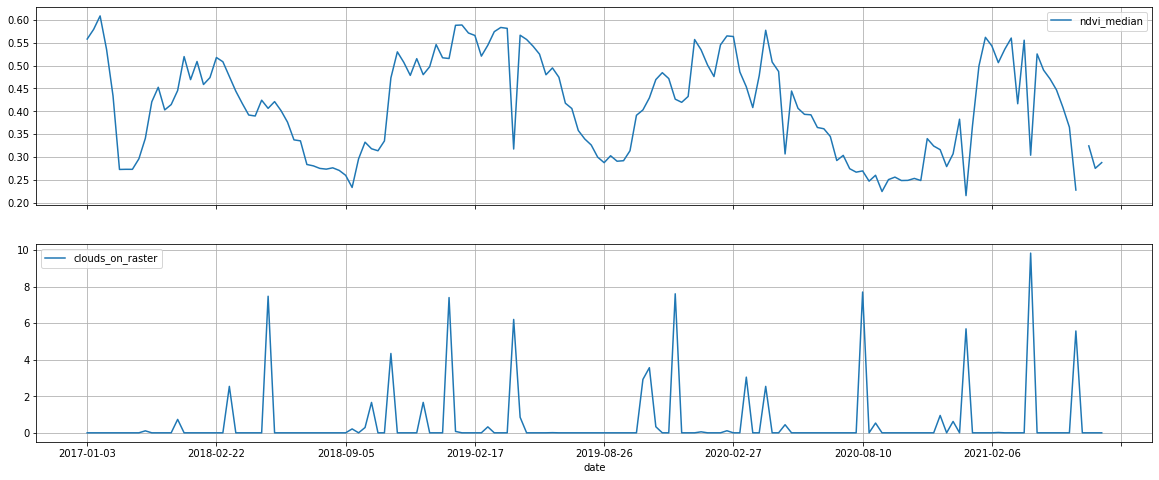

In [11]:
f, ax = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
pd_sarmiento[pd_sarmiento.clouds_on_raster < 10].plot(
    x="date", y="ndvi_median", ax=ax[0], grid=True
)
pd_sarmiento[pd_sarmiento.clouds_on_raster < 10].plot(
    x="date", y="clouds_on_raster", ax=ax[1], grid=True
)

### Forecasting

Vamos a intentar analizar la evolucion de un indice (ndvi) en su mediana. Algunos comentarios:

- Vamos a desechar nubes (clouds_on_raster == 0)
- Vamos a resamplear con una frecuencia mensual

In [12]:
pd_proc = pd_sarmiento.copy()
pd_proc = pd_proc[pd_proc.clouds_on_raster == 0]
pd_proc

,B02_min,B02_max,B02_mean,B02_median,B02_nodata,B02_range,B02_count,B03_min,B03_max,B03_mean,...,sipi_median,sipi_nodata,sipi_range,sipi_count,raster,clouds_on_raster,osm_id,name,area_m2,date
173,0.0751,0.3991,0.104646,0.0987,0.0,0.3240,8588,0.0590,0.4087,0.101785,...,0.902752,0.0,3.402823e+38,8588,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,0.0,6170329,Parque Sarmiento,859608.565917,2017-01-03
2850,0.0671,0.4258,0.097588,0.0920,0.0,0.3587,8588,0.0498,0.4176,0.094457,...,0.890146,0.0,4.276148e+01,8588,S2A_MSIL1C_20170212T142031_N0204_R010_T20JLL_2...,0.0,6170329,Parque Sarmiento,859608.565917,2017-02-12
3201,0.0694,0.3862,0.097503,0.0912,0.0,0.3168,8588,0.0485,0.3957,0.093673,...,0.885194,0.0,3.338491e+01,8588,S2A_MSIL1C_20170222T142031_N0204_R010_T20JLL_2...,0.0,6170329,Parque Sarmiento,859608.565917,2017-02-22
4365,0.0708,0.3906,0.103186,0.0979,0.0,0.3198,8588,0.0499,0.3976,0.098484,...,0.899257,0.0,1.148243e+02,8588,S2A_MSIL1C_20170314T142031_N0204_R010_T20JLL_2...,0.0,6170329,Parque Sarmiento,859608.565917,2017-03-14
7390,0.0842,0.4167,0.112552,0.1077,0.0,0.3325,8588,0.0561,0.4200,0.097212,...,0.788568,0.0,3.402823e+38,8588,S2A_MSIL1C_20170602T142041_N0205_R010_T20JLL_2...,0.0,6170329,Parque Sarmiento,859608.565917,2017-06-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172416,0.0841,0.5062,0.119585,0.1144,0.0,0.4221,8588,0.0533,0.5696,0.104007,...,0.820748,0.0,1.939972e+02,8588,S2A_MSIL1C_20210701T141741_N0301_R010_T20JLL_2...,0.0,6170329,Parque Sarmiento,859608.565917,2021-07-01
173527,NaN,NaN,NaN,NaN,8588.0,NaN,0,NaN,NaN,NaN,...,NaN,8588.0,NaN,0,S2A_MSIL1C_20210711T141741_N0301_R010_T20JLL_2...,0.0,6170329,Parque Sarmiento,859608.565917,2021-07-11
174695,0.0852,0.4585,0.120288,0.1158,0.0,0.3733,8588,0.0544,0.4293,0.106136,...,0.852693,0.0,1.142367e+02,8588,S2B_MSIL1C_20210716T141739_N0301_R010_T20JLL_2...,0.0,6170329,Parque Sarmiento,859608.565917,2021-07-16
175799,0.0922,0.3682,0.130117,0.1257,0.0,0.2760,8588,0.0619,0.3662,0.117064,...,0.905969,0.0,2.459958e+02,8588,S2B_MSIL1C_20210805T141739_N0301_R010_T20JLL_2...,0.0,6170329,Parque Sarmiento,859608.565917,2021-08-05


In [13]:
pd_proc["date"] = pd.to_datetime(pd_proc["date"], format="%Y-%m-%d")

In [14]:
pd_proc.set_index("date", inplace=True)

In [15]:
df_stats = pd_proc.resample("M").median().bfill()

In [16]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [17]:
from statsmodels.tsa.seasonal import STL

In [18]:
data = df_stats["ndvi_max"]

In [19]:
res = STL(data).fit()

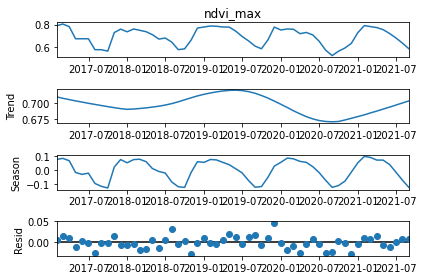

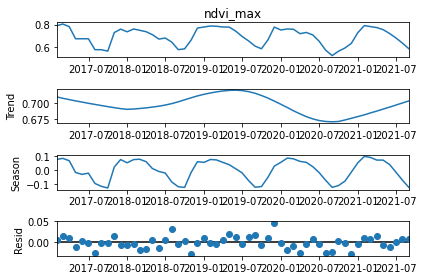

In [20]:
res.plot()

In [21]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [22]:
aust = data[:-12]

/data/proyectos/espacios-verdes-monitoreo/.pyenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/data/proyectos/espacios-verdes-monitoreo/.pyenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


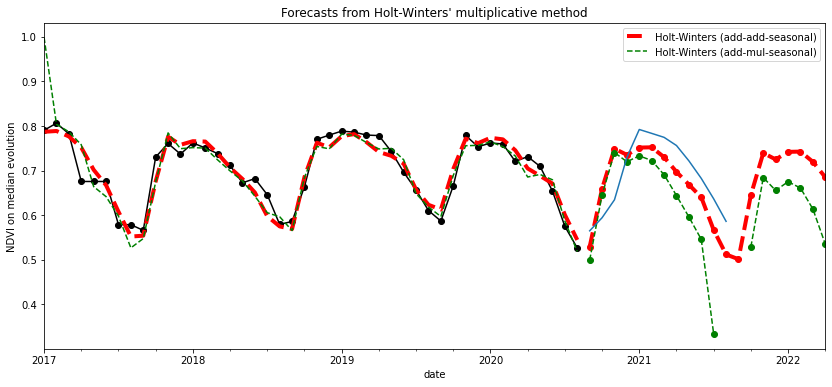

Figure: NDVI Median Forecasting


,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,0.358994,7.569554e-01,0.359065,1.000000e+00
$\beta$,0.000042,0.000000e+00,0.000037,4.301311e-01
$\phi$,NaN,NaN,0.990117,8.000000e-01
$\gamma$,0.000042,2.140378e-03,0.000037,2.121453e-09
$l_0$,-0.183865,6.460263e-19,-0.183641,2.457355e-18
$b_0$,-0.000349,-2.047415e-03,-0.000453,-1.280568e-01
SSE,0.025339,7.153369e-02,0.025498,1.333929e-01


In [23]:
fit1 = ExponentialSmoothing(
    aust,
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit2 = ExponentialSmoothing(
    aust,
    seasonal_periods=12,
    trend="add",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit3 = ExponentialSmoothing(
    aust,
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit4 = ExponentialSmoothing(
    aust,
    seasonal_periods=12,
    trend="add",
    seasonal="mul",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE"]
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
results["Additive"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

ax = aust.plot(
    figsize=(14, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
)
ax.set_ylabel("NDVI on median evolution")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style="--", color="red", lw=4)
fit2.fittedvalues.plot(ax=ax, style="--", color="green")

fit1.forecast(20).rename("Holt-Winters (add-add-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", lw=4, legend=True
)
fit2.forecast(20).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)
data[-12:].plot(ax=ax)
plt.show()
print("Figure: NDVI Median Forecasting")

results